In [1]:
import json
import numpy as np
import pandas as pd

In [2]:
PATH='datasets/'
csvfiles = ['links.csv','movies.csv','ratings.csv']

In [3]:
# load movielens datasets

def loadMovieLens(path=PATH):
    linksdf = pd.read_csv(path+csvfiles[0])
    moviesdf = pd.read_csv(path+csvfiles[1])
    ratingsdf = pd.read_csv(path+csvfiles[2])
    
    return linksdf, moviesdf, ratingsdf

In [4]:
linksdf, moviesdf, ratingsdf = loadMovieLens()


## Raw data transformation

### 1. Merging IMDb linksdf with moviesdf

In [5]:
moviesdf['imdbid']=linksdf.imdbId

### 2. movies.json

In [6]:
moviesdf.head()

,movieId,title,genres,imdbid
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709
1,2,Jumanji (1995),Adventure|Children|Fantasy,113497
2,3,Grumpier Old Men (1995),Comedy|Romance,113228
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,114885
4,5,Father of the Bride Part II (1995),Comedy,113041


In [7]:
# extract years 
moviesdf['year'] = moviesdf.title.str.extract(r'\((\d\d\d\d)\)', expand=False)

In [8]:
# clean title
moviesdf.title = moviesdf.title.str.replace(r'(\(\d+\))', '')
moviesdf.title = moviesdf.title.str.strip()

In [9]:
# cleaning genres
moviesdf.genres = moviesdf.genres.str.split('|')

In [10]:
moviesdf.head()

,movieId,title,genres,imdbid,year
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",114709,1995
1,2,Jumanji,"[Adventure, Children, Fantasy]",113497,1995
2,3,Grumpier Old Men,"[Comedy, Romance]",113228,1995
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",114885,1995
4,5,Father of the Bride Part II,[Comedy],113041,1995


In [11]:
moviesdf.year.fillna(-1, inplace=True)

In [12]:
i_movieId, i_title, i_genres, i_imdbid, i_year = 0, 1, 2, 3, 4
movies = {}
for row in moviesdf.iterrows():
    row=row[1]
    moviedId = str(row[i_movieId])
    
    movies.setdefault(moviedId, {})        
    
    movies[moviedId] = dict(title=row[i_title], genres=row[i_genres], imdbid=row[i_imdbid], year=row[i_year])
    
    

In [13]:
import json
json.dump(movies, open('movielens/movies.json','w+'))

__format :: movies.json__:

{

    _movieId_: {

        'title': _movie title_,

        'genres': [ _genre1_, _genre2_, ..],

        'year': _year of release_,

        'imdb': _IMDb id of movie_
     },
     .
     .
     .
}

movies.json is a dictionary of movie objects formated as above

### 3. genres.json

In [14]:
genres={}
for movie in movies.keys():
    
    # genres of this movie
    genrelist=movies[movie]['genres']
    
    # each genre in genrelist
    for g in genrelist:
        genres.setdefault(g,[])
        # classifing movies against genres
        genres[g].append(movie)



In [15]:
json.dump(genres,open('movielens/genres.json','w'))

__format :: genres.json__

{

    genre1: [ _movieId1_, _movieId2, ..],
    genre2: [ _movieId1_, _movieId2, ..],
    .
    .
    .

}

key: genre(string)

item: list of movieIds of key genre

### 4. years.json

In [16]:
years={}
for movie in movies.keys():
    
    # genres of this movie
    year=str(movies[movie]['year'])
    
    if year==-1: continue
    
    years.setdefault(year,[])
    years[year].append(movie)



In [17]:
json.dump(years, open('movielens/years.json','w'))

### 4. ratings.json

In [18]:
ratingsdf.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [174]:
ratings = {}
user_history = {}
for row in ratingsdf.iterrows():
    row=row[1]
    userId = str(int(row[0]))
    movieId = str(int(row[1]))
    rating = row[2]
    timestamp = str(int(row[3]))
    
    ratings.setdefault(userId,{})
    ratings[userId].setdefault('data',{})
    ratings[userId].setdefault('meta',{})
    ratings[userId]['data'].setdefault(movieId,{})
    
    ratings[userId]['data'][movieId] = dict(rating=rating, timestamp=timestamp)
    
for user in ratings.keys():
    rs=0
    for i,movie in enumerate(ratings[user]['data'].keys()):
        rs+=ratings[user]['data'][movie]['rating']
    
    ratings[user]['meta']['average_rating']=rs/i

In [191]:
json.dump(ratings, open('movielens/ratings.json', 'w+'))

__format :: ratings.json__

{

    userId: {

        movieId1: {
            'rating': 0.0-5.0,
            'timestamp': when rated
        },
        .
        .
        .
    },
    .
    .
    .
}

__desc__

1. ratings.json is a dictionary of all movie ratings
2. each user who ever rated a movie has an object in this dictionary
3. each user object is a dictionary of rating objects
4. each rating object has movieId as key and two properties:
    1. user rating of that movie
    2. timestamp of rating

### 5. Transposed Ratings

Iterchange movieId keys with userId keys

In [296]:
def transpose(prefs):
    tp={}
    meta={}
    for user in prefs:
        for item in prefs[user]['data']:
            
            tp.setdefault(item,{})
            tp[item].setdefault('data',{})
            tp[item].setdefault('meta',{})
            
            tp[item]['data'][user]=prefs[user]['data'][item]
            
            meta.setdefault(item, {})
            meta[item].setdefault('rated_by', 0)
            meta[item].setdefault('ratings_sum', 0)
            
            meta[item]['rated_by']+=1
            meta[item]['ratings_sum']+=prefs[user]['data'][item]['rating']
    
    for movie in tp:
        tp[movie]['meta']['average_rating']=meta[movie]['ratings_sum']/meta[movie]['rated_by']
    
    return tp

In [300]:
trans_ratings = transpose(ratings)
json.dump(trans_ratings, open('movielens/ratings-transpose.json', 'w'))

__format :: ratings-transpose.json__

{

    movieId: {

        userId: {
            'rating': x in (0.0, 5.0)
            'timestamp': when rated
        },
        .
        .
        .
    },
    .
    .
    .
}

## User - Genre Preference Model

will calculate preference of each genre for each user

In [194]:
import math

### Genre Frequency in User Ratings

In [195]:
def user_genre_occurence_frequency(prefs, genres, userId, genre):
    '''
    TODO:
        find occurence rate of a genre in user ratings weighted by rating of movies
    
    HOW:
        R(u, m) :
            returns ratings by user 'u' for movie 'm'.

        T(u, M)
            returns total number of movies rated by user 'u' 

        gf(u, g) = sum( R(u, m); all m in Mu and m of g ) / T(u, M) 
            ; Mu is set of movies rated by 'u'
        
            returns occurrence frequency of a particular genre 'g' with user 'u' weighted by
            movie ratings.
    
    WHY:
        1. it shows how much of a genre 'g' appeares in user ratings
        
        2. high value signifies high inclination towards movies of that genre
    
    RETURN: 
        gf(u, g)
    
    
    NOTES: 
        1. analogous to Term Frequency from TF-IDF model
    '''
    
    userPrefs = prefs[userId]['data']
    
    # total number of movies rated by user; T(u, M)
    numRatings=len(userPrefs.keys())
    
    # if no movies rated by user
    if numRatings==0: return 0
    
    # sum of all movie ratings of this genre; sum( R(u, m) m belongs to Mu and m of g )
    sumGenreRatings = sum([ userPrefs[movie]['rating'] for movie in genres[genre] if movie in userPrefs.keys() ])
    
    # gf(u, g)
    return sumGenreRatings/numRatings

### Logged inverse genre occurence frequency

In [196]:
def inverse_genre_occurence_frequency(movies, genres, genre):
    '''
    TODO: 
        find log of inverse occurence frequncy of a genre in all of movies.
    
    HOW:
        T(g, M)
            returns total number of movies of genre 'g' in universal movie set 'M'
        
        T(M)
            returns total number of movies in 'M'
        
        IGF(g, M) = log( T(M)/T(g, M) )
            returns log of inverse genre frequency of genre 'g' in 'M'
    
    WHY:
        1. It shows the importance of a genre 'g'; importance increases with value
        2. Genres which appear in many movies are not very distinctive hence, not very important
           for making recommendations.
    
    RETURN:
        IGF(g, M)
    
    NOTES: analogous to Inverse Document Frequency from TF-IDF model
    '''
    # total number of movies in all the dataset; T(M)
    N = len(movies.keys())
    
    # total number of movies of this genre; T(g, M)
    n = len(genres[genre])
    
    # log of inverse genre frequency; IGF(g, M)
    return math.log(N/n)
    

### Genre Preference Score

In [197]:
def user_genre_preference_score(prefs, movies, genres, userId, genre):
    '''
    TODO: 
        calculate a user's preference score for the given genre
    
    HOW:
        gf(u, g)
            preference score of genre 'g' for user 'u'
            
        IGF(g, M)
            inverse genre frequency of genre 'g' in universal movie set 'M'
        
        p(u, g) = gf(u, g) * IGF(g, M)
            returns user 'u' preference score for genre 'g'
    
    WHY:
        1. this stat shows user 'u's subjective preference for the given genre
        
        2. if user 'u' has seen many movies of genre 'g'; T(u, M) is high and p(u, g) is high, it shows that 
           user 'u' has high degree of preference for genre 'g' and would like to watch more 
           movies of this genre. 
           Recommed more movies of genre 'g'
        
        3. if user 'u' has seen many movies of genre 'g'; T(u, M) is high but p(u, g) is low, it shows that
           user 'u' is intrested in genre 'g' but haven't found satisfying movies of this genre. 
           Recommend top rated movies of this genre filtered by similar users
           
        4. if user 'u' has not seen many movies of genre 'g'; T(u, M) is low but p(u, g) is high, it shows that
           user 'u' might not be inclined towards genre 'g' but have found the movies they saw intresting.
           Recommend top rated movies of this genre filtered by similar users
        
        5. if user 'u' has not seen many movies of genre 'g'; T(u, M) is low and p(u, g) is low, it shows that
           user 'u' is not intrested in this genre and didn't liked the movies they saw.
    
    RETURN: 
            p(u, g)
        
    
    NOTES: analogous to IT-IDF model
    '''
    
    # tf of genre; gf(u, g)
    gf = user_genre_occurence_frequency(prefs, genres, userId, genre)
    
    # idf of genre; IGF(g, M)
    igf = inverse_genre_occurence_frequency(movies, genres, genre)
    
    return gf*igf
    

### Creating Genre Preference Dictionary

In [198]:
def create_user_genre_preference_dictionary(prefs, movies, genres):
    '''
    TODO: create a dictionary of normalized genre preferences of all users for all genres
    '''
    gps={}

    # all userIds
    for userId in prefs.keys():
        s=0 # sum of genre pref scores for userId; to normalize the score vector

        # all genres
        for genre in genres.keys():
            gps.setdefault(userId,{})
            gps[userId].setdefault('meta',{})
            gps[userId].setdefault('data',{})

            # genre pref score for userId for this genre
            score = user_genre_preference_score(prefs, movies, genres, userId, genre)
            
            s+=score
            gps[userId]['data'][genre] = score

        # normalization
        for genre in gps[userId]['data'].keys():
            gps[userId]['data'][genre]= round(gps[userId]['data'][genre]/s,5)
        
        r_sum=0
        genre_rated=0
        wmax=0
        fav_genre=''
        
        for genre in gps[userId]['data'].keys():
            w=gps[userId]['data'][genre]
            r_sum+=w
            if w!=0:genre_rated+=1
            
            if wmax<w:
                fav_genre=genre
                wmax=w
        
        
        gps[userId]['meta']['fav_genre']=fav_genre
        gps[userId]['meta']['average_weight']=r_sum/genre_rated
    
    return gps


In [199]:
gps = create_user_genre_preference_dictionary(ratings, movies, genres)
json.dump(gps, open('movielens/user-genre-preferences.json','w'))

__format :: user-genre-preferences.json__

{

    userId: {    
        
        'data': {
            genre: preference score,
            genre: preference score,
            .
            .
            .
         },
         
         'meta': {
             'fav_genre': fav genre,
             'avg_weight': average of all genre weights
         }
     }
     .
     .
     .

}

__desc__
1. dictionary of genre preference scores for all genres of all users

## Item-Genre Importance Model

will calculate weight of a genre in a movie

In [301]:
with open('movielens/ratings-transpose.json','r') as tr:
    trans_prefs=json.load(tr)

In [302]:
with open('movielens/ratings.json','r') as rj:
    prefs = json.load(rj)

In [303]:
with open('movielens/user-genre-preferences.json','r') as rj:
    genre_prefs = json.load(rj)

with open('movielens/movies.json','r') as rj:
    movies = json.load(rj)

In [259]:
def have_rated_with_ratings(prefs, movie):
    users=[]
    for user in prefs.keys():
        if movie in prefs[user]['data'].keys():
            users.append([user, prefs[user]['data'][movie]['rating']])
    return np.array(users)

In [204]:
users = have_rated_with_ratings(prefs, '1')

In [205]:
def movie_genre_weight(prefs,genres, movies, genre_prefs, movie, genre):
    
    # all users who rated this movie
    r_users = have_rated_with_ratings(prefs, movie)
    
    s=0
    gc={}
    for row in r_users:
        # rating sum of movies with given genre
        s+=float(row[1])*genre_prefs[row[0]]['data'][genre]
        
        # number of genres rated by the users who rated given movie
        for g,r in genre_prefs[row[0]]['data'].items():
            if r:
                gc[g]=1
    
    
    try: return s/len(gc.keys())*inverse_genre_occurence_frequency(genres=genres, movies=movies, genre=genre)
    except: return 0
    
    

In [315]:
#def create_movies_genre_weight_dictionary()

genre_weight={}

c=0
for movie in movies.keys():
    s=0
    genre_weight.setdefault(movie,{})
    genre_weight[movie].setdefault('data',{})
    genre_weight[movie].setdefault('meta',{})
    
    movie_genre = movies[movie]['genres']
    
    
    c+=1
    if not c%500: 
        print(c,' movies weighed')
    
    for genre in genres.keys():
        if genre not in movie_genre:
            w=0
        else:
            w=movie_genre_weight(prefs, genres, movies, genre_prefs, movie, genre)
            
        genre_weight[movie]['data'][genre] = w
        
        s+=w
    
    wmax=0
    heaviest_genre=''
    w_sum=0
    for g,w in genre_weight[movie]['data'].items():
        try: genre_weight[movie]['data'][g]=w/s
        except: genre_weight[movie]['data'][g]=w
        norm_weight=genre_weight[movie]['data'][g]
        
        w_sum+=norm_weight
        
        if wmax<norm_weight:
            wmax=norm_weight
            heaviest_genre=genre
    
    genre_weight[movie]['meta']['heaviest_genre']=heaviest_genre
    genre_weight[movie]['meta']['average_genre_weight']=w_sum/len(movie_genre)    

500  movies weighed
1000  movies weighed
1500  movies weighed
2000  movies weighed
2500  movies weighed
3000  movies weighed
3500  movies weighed
4000  movies weighed
4500  movies weighed
5000  movies weighed
5500  movies weighed
6000  movies weighed
6500  movies weighed
7000  movies weighed
7500  movies weighed
8000  movies weighed
8500  movies weighed
9000  movies weighed


In [317]:
json.dump(genre_weight, open('movielens/movie-genre-weights.json', 'w'))

In [318]:
movie_genre_weights=json.load(open('movielens/movie-genre-weights.json'))

In [209]:
def get_common_movies(prefs,u1,u2):
    u1m=set(prefs['13'].keys())
    u2m=set(prefs['10'].keys())
    si = u1m.union(u2m)
    return si

In [276]:
genre_prefs['1']['meta']['average_weight']

0.06666666666666667

In [210]:
def sim_users(genre_prefs,u1,u2):
    u1prefs=genre_prefs[u1]['data']
    u2prefs=genre_prefs[u2]['data']
    
    u1meta=genre_prefs[u1]['meta']
    u2meta=genre_prefs[u2]['meta']
    
    avg_w = u1meta['average_weight']
    avg2_w = u2meta['average_weight']

    wu1t=[]
    for genre, w in u1prefs.items():
        wu1t.append(w)

    wu2t=[]
    for genre, w in u2prefs.items():
        wu2t.append(w)
    
    # dot product of genreprefs normalized by mean genre weight
    n= (np.array(wu1t)-avg_w).dot(np.array(wu2t)-avg2_w)
    
    # product of magnitudes
    d = np.linalg.norm(np.array(wu1t)-avg_w)*np.linalg.norm(np.array(wu2t)-avg2_w)

    return round(n/d,5)

In [211]:
sim_users(genre_prefs,'71','70')

0.20663000000000001

In [344]:
def sim_movie(genre_weights, movie1, movie2):
    
    wm1=[]
    wm2=[]
    
    avg1=genre_weights[movie1]['meta']['average_genre_weight']
    avg2=genre_weights[movie2]['meta']['average_genre_weight']
    
    for genre, w in genre_weights[movie1]['data'].items():
        wm1.append(w-avg1)
        
    for genre, w in genre_weights[movie2]['data'].items():
        wm2.append(w-avg2)
    
    wm1=np.array(wm1)
    wm2=np.array(wm2)
    
    n=wm1.dot(wm2)
    d=np.linalg.norm(wm1)*np.linalg.norm(wm2)
    
    return round(n/d,4)

In [345]:
U=ratingsdf.userId.astype('str').unique()

In [346]:
prefs['1']['meta']

{'average_rating': 2.6842105263157894}

In [391]:
def predict(prefs, trans_prefs, genre_prefs, movie_genre_weights, user, movie, sigma=0.5):
    
    useravgR=prefs[user]['meta']['average_rating']
    movieavgR=trans_prefs[movie]['meta']['average_rating']
    
    otherRatings=have_rated_with_ratings(prefs, movie)
    
    n1,d1=0,0
    for other,rating in otherRatings:
        otheravgR=prefs[other]['meta']['average_rating']
        score=sim_users(genre_prefs, user, other)
        
        n1+=score*(float(rating)-otheravgR)
        d1+=score
    
    n2,d2=0,0
    for other_movie in prefs[user]['data'].keys():
        otheravgR=trans_prefs[other_movie]['meta']['average_rating']
        score=sim_movie(movie_genre_weights, movie, other_movie)
        
        n2+=score*(prefs[user]['data'][other_movie]['rating']-otheravgR)
        d2+=score
    
    return sigma*(useravgR+(n1/d1))+(1-sigma)*(movieavgR+(n2/d2))



In [409]:
%%timeit
predict(prefs, trans_prefs, genre_prefs, movie_genre_weights, '1', '1', sigma=0.5)

12.9 ms ± 71.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [431]:
err=[]

for sigma in [i/10 for i in range(1,15)]:
    for user in [str(i) for i in range(1,20)]:
        for movie in prefs[user]['data'].keys():
            s=prefs[user]['data'][movie]['rating']
            p=predict(prefs, trans_prefs, genre_prefs, movie_genre_weights, user,'2455',sigma=sigma)

            err.append([sigma, math.sqrt((s-p)**2)])

err = pd.DataFrame(np.array(err), columns=['sigma','rmse'])


In [432]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [439]:
err.groupby(err.sigma).describe().style.background_gradient(cmap=plt.cm.summer_r)

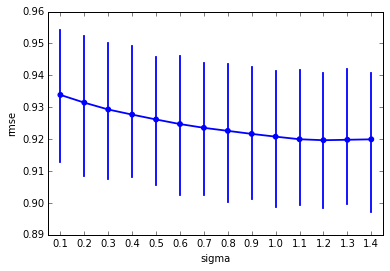

In [434]:
sns.pointplot(err.sigma, err.rmse)

In [441]:
prefs['1']['data']

{'1029': {'rating': 3.0, 'timestamp': '1260759179'},
 '1061': {'rating': 3.0, 'timestamp': '1260759182'},
 '1129': {'rating': 2.0, 'timestamp': '1260759185'},
 '1172': {'rating': 4.0, 'timestamp': '1260759205'},
 '1263': {'rating': 2.0, 'timestamp': '1260759151'},
 '1287': {'rating': 2.0, 'timestamp': '1260759187'},
 '1293': {'rating': 2.0, 'timestamp': '1260759148'},
 '1339': {'rating': 3.5, 'timestamp': '1260759125'},
 '1343': {'rating': 2.0, 'timestamp': '1260759131'},
 '1371': {'rating': 2.5, 'timestamp': '1260759135'},
 '1405': {'rating': 1.0, 'timestamp': '1260759203'},
 '1953': {'rating': 4.0, 'timestamp': '1260759191'},
 '2105': {'rating': 4.0, 'timestamp': '1260759139'},
 '2150': {'rating': 3.0, 'timestamp': '1260759194'},
 '2193': {'rating': 2.0, 'timestamp': '1260759198'},
 '2294': {'rating': 2.0, 'timestamp': '1260759108'},
 '2455': {'rating': 2.5, 'timestamp': '1260759113'},
 '2968': {'rating': 1.0, 'timestamp': '1260759200'},
 '31': {'rating': 2.5, 'timestamp': '126075914

In [447]:
movies['1172']

{'genres': ['Drama'],
 'imdbid': 95765,
 'title': 'Cinema Paradiso (Nuovo cinema Paradiso)',
 'year': '1989'}

In [445]:
predict(prefs=prefs, trans_prefs=trans_prefs, genre_prefs=genre_prefs, movie_genre_weights=movie_genre_weights, user='1', movie='1172', sigma=1.2)

3.1211528505687349